# Employment and Earnings

[TidyTuesday 2021-02-23](https://github.com/rfordatascience/tidytuesday/blob/master/data/2021/2021-02-23/readme.md)

**Contents:**

* [Setup and data load](#Setup-and-data-load)
* [Data Understanding](#Data-Understanding)
* [Brainstorm](#Brainstorm)
* [Industries](#Industries)
* [Occupations](#Occupations)

## Setup and data load

In [6]:
using DataFrames, CSV
using Pipe
using Dates
using StatsBase


using StatsPlots
using Measures
using FStrings

import PyPlot as plt

In [7]:
ENV["COLUMNS"] = 1000

1000

In [8]:
ENV["LINES"] = 50

50

In [9]:
baseurl = "https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2021/2021-02-23/";

In [11]:
employed = CSV.read(download(baseurl * "employed.csv"), DataFrame)
employed.industry = replace.(employed.industry, "\r\n" => " ")
employed.industry_total = replace(tryparse.(Int, employed.industry_total), nothing => missing)
employed.employ_n = replace(tryparse.(Int, employed.employ_n), nothing => missing)
employed = dropmissing(employed)
display(first(employed, 5))
display(size(employed))

5×7 DataFrame
 Row │ industry                 major_occupation                   minor_occupation                   race_gender  industry_total  employ_n  year  
     │ String                   String                             String                             String       Int64           Int64     Int64 
─────┼─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   1 │ Agriculture and related  Management, professional, and re…  Management, business, and financ…  TOTAL               2349000    961000   2020
   2 │ Agriculture and related  Management, professional, and re…  Professional and related occupat…  TOTAL               2349000     58000   2020
   3 │ Agriculture and related  Service occupations                Protective service occupations     TOTAL               2349000     13000   2020
   4 │ Agriculture and related  Service occupations                Service occupations, except prot…  TOTAL               2349000     94000   2020
   5 │ Agriculture and related  Sales and office occupations       Sales and related occupations      TOTAL               2349000     12000   2020

(7524, 7)

In [12]:
describe(employed, :nunique, :min, :max, :nmissing)

7×5 DataFrame
 Row │ variable          nunique  min                                max                                nmissing 
     │ Symbol            Union…   Any                                Any                                Int64    
─────┼───────────────────────────────────────────────────────────────────────────────────────────────────────────
   1 │ industry          19       Agriculture and related            Wholesale trade                           0
   2 │ major_occupation  5        Management, professional, and re…  Service occupations                       0
   3 │ minor_occupation  12       Construction and extraction occu…  Transportation and material movi…         0
   4 │ race_gender       6        Asian                              Women                                     0
   5 │ industry_total             18000                              35894000                                  0
   6 │ employ_n                   0                                  20263000                                  0
   7 │ year                       2015                               2020                                      0

In [13]:
earn = CSV.read(download(baseurl * "earn.csv"), DataFrame)
earn.date = @. Date(earn.year, 1 + 3*(earn.quarter-1), 1)
display(first(earn, 5))
display(size(earn))

5×9 DataFrame
 Row │ sex         race       ethnic_origin  age                year   quarter  n_persons  median_weekly_earn  date       
     │ String      String     String         String             Int64  Int64    Int64      Int64               Date       
─────┼────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   1 │ Both Sexes  All Races  All Origins    16 years and over   2010        1   96821000                 754  2010-01-01
   2 │ Both Sexes  All Races  All Origins    16 years and over   2010        2   99798000                 740  2010-04-01
   3 │ Both Sexes  All Races  All Origins    16 years and over   2010        3  101385000                 740  2010-07-01
   4 │ Both Sexes  All Races  All Origins    16 years and over   2010        4  100120000                 752  2010-10-01
   5 │ Both Sexes  All Races  All Origins    16 years and over   2011        1   98329000                 755  2011-01-01

(4224, 9)

In [14]:
describe(earn, :nunique, :min, :max, :nmissing)

9×5 DataFrame
 Row │ variable            nunique  min             max                 nmissing 
     │ Symbol              Union…   Any             Any                 Int64    
─────┼───────────────────────────────────────────────────────────────────────────
   1 │ sex                 3        Both Sexes      Women                      0
   2 │ race                4        All Races       White                      0
   3 │ ethnic_origin       2        All Origins     Hispanic or Latino         0
   4 │ age                 12       16 to 19 years  65 years and over          0
   5 │ year                         2010            2020                       0
   6 │ quarter                      1               4                          0
   7 │ n_persons                    103000          118358000                  0
   8 │ median_weekly_earn           318             1709                       0
   9 │ date                44       2010-01-01      2020-10-01                 0

## Data Understanding

### Employment

What are `major_occupation` and `minor_occupation`?

In [15]:
unique(employed[:,[:major_occupation,:minor_occupation]])

12×2 DataFrame
 Row │ major_occupation                   minor_occupation                  
     │ String                             String                            
─────┼──────────────────────────────────────────────────────────────────────
   1 │ Management, professional, and re…  Management, business, and financ…
   2 │ Management, professional, and re…  Professional and related occupat…
   3 │ Service occupations                Protective service occupations
   4 │ Service occupations                Service occupations, except prot…
   5 │ Sales and office occupations       Sales and related occupations
   6 │ Sales and office occupations       Office and administrative suppor…
   7 │ Natural resources, construction,…  Farming, fishing, and forestry o…
   8 │ Natural resources, construction,…  Construction and extraction occu…
   9 │ Natural resources, construction,…  Installation, maintenance, and r…
  10 │ Production, transportation, and …  Production occupations
  11 │ Production, transportation, and …  Transportation and material movi…
  12 │ Management, professional, and re…  Manage-ment, business, and finan…

Ok, so regardless of overall industry, data are tracked for these fixed subdivisions of labor types.

What about `industry_total`?  Consider agriculture / 2020 data as an example:

In [16]:
ag = employed[startswith.(employed.industry, "Ag") .& (employed.year .== 2020), : ]
first(ag, 5)

5×7 DataFrame
 Row │ industry                 major_occupation                   minor_occupation                   race_gender  industry_total  employ_n  year  
     │ String                   String                             String                             String       Int64           Int64     Int64 
─────┼─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   1 │ Agriculture and related  Management, professional, and re…  Management, business, and financ…  TOTAL               2349000    961000   2020
   2 │ Agriculture and related  Management, professional, and re…  Professional and related occupat…  TOTAL               2349000     58000   2020
   3 │ Agriculture and related  Service occupations                Protective service occupations     TOTAL               2349000     13000   2020
   4 │ Agriculture and related  Service occupations                Service occupations, except prot…  TOTAL               2349000     94000   2020
   5 │ Agriculture and related  Sales and office occupations       Sales and related occupations      TOTAL               2349000     12000   2020

In [17]:
first(sort(unique(select(ag, Not(:employ_n))), :industry_total), 20)

20×6 DataFrame
 Row │ industry                 major_occupation                   minor_occupation                   race_gender                industry_total  year  
     │ String                   String                             String                             String                     Int64           Int64 
─────┼─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   1 │ Agriculture and related  Management, professional, and re…  Management, business, and financ…  Asian                               28000   2020
   2 │ Agriculture and related  Management, professional, and re…  Professional and related occupat…  Asian                               28000   2020
   3 │ Agriculture and related  Service occupations                Protective service occupations     Asian                               28000   2020
   4 │ Agriculture and related  Service occupations                Service occupations, except prot…  Asian                               28000   2020
   5 │ Agriculture and related  Sales and office occupations       Sales and related occupations      Asian                               28000   2020
   6 │ Agriculture and related  Sales and office occupations       Office and administrative suppor…  Asian                               28000   2020
   7 │ Agriculture and related  Natural resources, construction,…  Farming, fishing, and forestry o…  Asian                               28000   2020
   8 │ Agriculture and related  Natural resources, construction,…  Construction and extraction occu…  Asian                               28000   2020
   9 │ Agriculture and related  Natural resources, construction,…  Installation, maintenance, and r…  Asian                               28000   2020
  10 │ Agriculture and related  Production, transportation, and …  Production occupations             Asian                               28000   2020
  11 │ Agriculture and related  Production, transportation, and …  Transportation and material movi…  Asian                               28000   2020
  12 │ Agriculture and related  Management, professional, and re…  Management, business, and financ…  Black or African American           66000   2020
  13 │ Agriculture and related  Management, professional, and re…  Professional and related occupat…  Black or African American           66000   2020
  14 │ Agriculture and related  Service occupations                Protective service occupations     Black or African American           66000   2020
  15 │ Agriculture and related  Service occupations                Service occupations, except prot…  Black or African American           66000   2020
  16 │ Agriculture and related  Sales and office occupations       Sales and related occupations      Black or African American           66000   2020
  17 │ Agriculture and related  Sales and office occupations       Office and administrative suppor…  Black or African American           66000   2020
  18 │ Agriculture and related  Natural resources, construction,…  Farming, fishing, and forestry o…  Black or African American           66000   2020
  19 │ Agriculture and related  Natural resources, construction,…  Construction and extraction occu…  Black or African American           66000   2020
  20 │ Agriculture and related  Natural resources, construction,…  Installation, maintenance, and r…  Black or African American           66000   2020

It seems that `industry_total` is a sum over major/minor occupations within any industry/race_gender combination.

### Earnings

In [18]:
for col in [:sex, :race, :ethnic_origin, :age]
    display(col)
    display(unique(earn[!,col]))
end

:sex

3-element Vector{String}:
 "Both Sexes"
 "Men"
 "Women"

:race

4-element Vector{String}:
 "All Races"
 "White"
 "Black or African American"
 "Asian"

:ethnic_origin

2-element Vector{String}:
 "All Origins"
 "Hispanic or Latino"

:age

12-element Vector{String}:
 "16 years and over"
 "16 to 24 years"
 "16 to 19 years"
 "20 to 24 years"
 "25 years and over"
 "25 to 54 years"
 "25 to 34 years"
 "35 to 44 years"
 "45 to 54 years"
 "55 years and over"
 "55 to 64 years"
 "65 years and over"

## Brainstorm

**Employment**
* Examine by industry, aggregating over occupation types (use industry_total)
* Examine by occupation, aggregating over industries (use employ_n and compute any totals manually)
* Consider frac_men and frac_white
* Consider time dependence

## Industries

In [19]:
industries = @pipe employed |> 
    select(_, Not([:major_occupation, :minor_occupation, :employ_n])) |>
    unique |>
    unstack(_, [:industry,:year], :race_gender, :industry_total)
industries.perc_men = @. 100 * industries.Men / industries.TOTAL
industries.perc_white = @. 100 * industries.White / industries.TOTAL
industries_latest = @pipe industries |>
    filter(:year => ==(max(industries.year...)), _)
industries_latest

19×10 DataFrame
 Row │ industry                           year   TOTAL     Men       Women     White     Black or African American  Asian    perc_men  perc_white 
     │ String                             Int64  Int64?    Int64?    Int64?    Int64?    Union{Missing, Int64}      Int64?   Float64   Float64    
─────┼────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   1 │ Agriculture and related             2020   2349000   1699000    650000   2170000                      66000    28000   72.3287     92.3797
   2 │ Mining, quarrying, and oil and g…   2020    684000    585000     99000    596000                      31000    29000   85.5263     87.1345
   3 │ Construction                        2020  10786000   9613000   1173000   9552000                     647000   216000   89.1248     88.5592
   4 │ Manufacturing                       2020  14550000  10255000   4295000  11600000                    1492000  1024000   70.4811     79.7251
   5 │ Durable goods                       2020   9129000   6814000   2314000   7332000                     868000   674000   74.6413     80.3155
   6 │ Nondurable goods                    2020   5421000   3441000   1981000   4268000                     624000   350000   63.4754     78.7309
   7 │ Wholesale and retail trade          2020  18989000  10634000   8355000  14911000                    2232000  1080000   56.0008     78.5244
   8 │ Wholesale trade                     2020   3380000   2358000   1022000   2805000                     298000   182000   69.7633     82.9882
   9 │ Retail trade                        2020  15609000   8276000   7333000  12106000                    1934000   898000   53.0207     77.5578
  10 │ Transportation and utilities        2020   8552000   6492000   2059000   6196000                    1599000   464000   75.9121     72.4509
  11 │ Information                         2020   2594000   1544000   1050000   1974000                     298000   252000   59.522      76.0987
  12 │ Financial activities                2020  10646000   5121000   5524000   8431000                    1115000   837000   48.1026     79.1941
  13 │ Professional and business servic…   2020  18816000  11031000   7785000  14605000                    1868000  1790000   58.6256     77.6201
  14 │ Education and health services       2020  34105000   8672000  25432000  25818000                    5055000  2132000   25.4274     75.7015
  15 │ Leisure and hospitality             2020  11480000   5694000   5786000   8690000                    1463000   726000   49.5993     75.6969
  16 │ Other services                      2020   6742000   3198000   3544000   5296000                     693000   516000   47.434      78.5524
  17 │ Other services, except private h…   2020   6088000   3125000   2963000   4772000                     630000   478000   51.3305     78.3837
  18 │ Private households                  2020    654000     73000    581000    523000                      62000    38000   11.1621     79.9694
  19 │ Public administration               2020   7501000   4020000   3481000   5502000                    1314000   344000   53.5929     73.3502

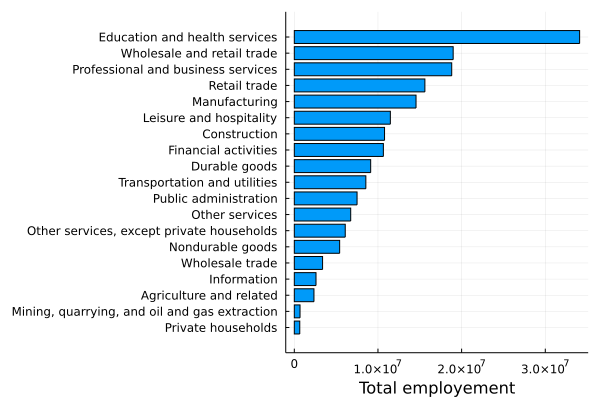

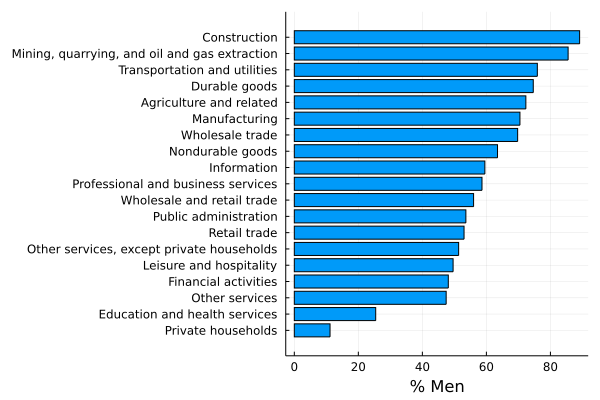

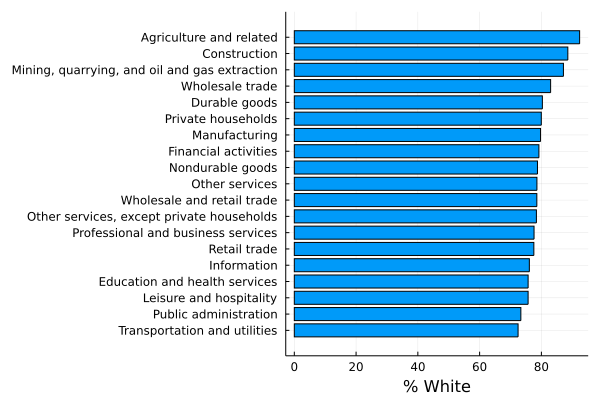

In [20]:
labels = [
    (:TOTAL, "Total employement"),
    (:perc_men, "% Men"),
    (:perc_white, "% White"),
]
for (col, label) in labels
    x = sort(industries_latest, col)
    display(bar(x.industry, x[!,col],
        orientation = :horizontal,
        yticks = :all,
        legend = false,
        xlabel = label,
    ))
end

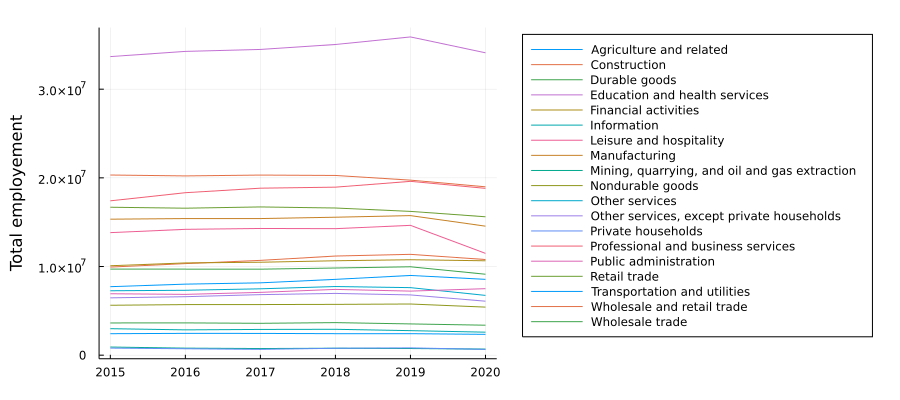

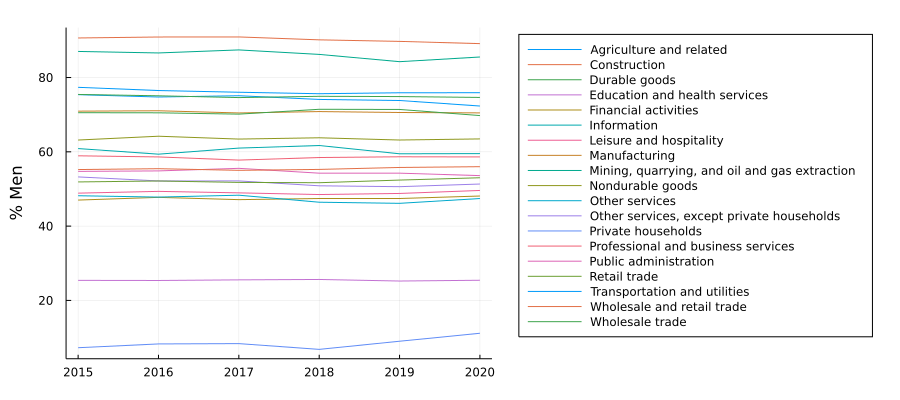

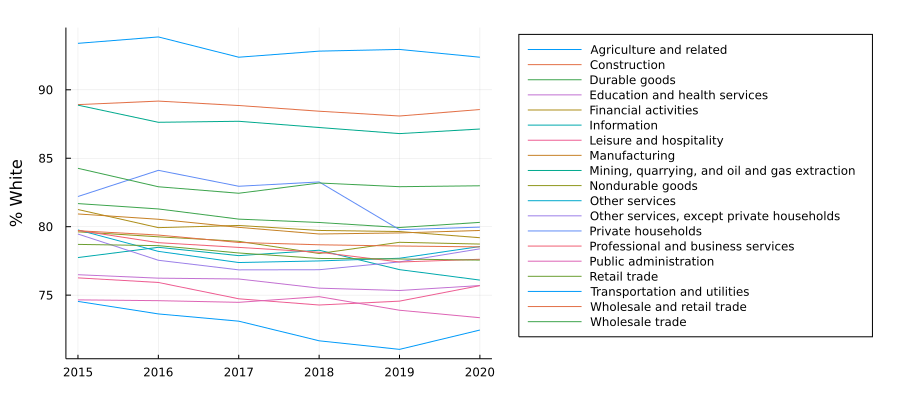

In [21]:
labels = [
    (:TOTAL, "Total employement"),
    (:perc_men, "% Men"),
    (:perc_white, "% White"),
]
for (col, label) in labels
    display(
        plot(
            industries.year, industries[!,col],
            group = industries.industry,
            legend = :outerright,
            ylabel = label,
            size=(900,400),
            margin = 5mm,
        )
    )
end

## Occupations

### Major occupations

In [22]:
major_occupations = @pipe employed |>
    groupby(_, [:major_occupation, :race_gender, :year]) |>
    combine(_, :employ_n => sum) |>
    unstack(_, [:major_occupation, :year], :race_gender, :employ_n_sum)
major_occupations.perc_men = @. 100 * major_occupations.Men / major_occupations.TOTAL
major_occupations.perc_white = @. 100 * major_occupations.White / major_occupations.TOTAL
major_occupations_latest = @pipe major_occupations |>
    filter(:year => ==(max(industries.year...)), _)
major_occupations_latest

5×10 DataFrame
 Row │ major_occupation                   year   TOTAL     Men       Women     White     Black or African American  Asian    perc_men  perc_white 
     │ String                             Int64  Int64?    Int64?    Int64?    Int64?    Union{Missing, Int64}      Int64?   Float64   Float64    
─────┼────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   1 │ Management, professional, and re…   2020  73314000  36662000  36656000  57879000                    6906000  6411000   50.0068     78.9467
   2 │ Service occupations                 2020  26166000  10761000  15409000  19105000                    4280000  1644000   41.1259     73.0146
   3 │ Sales and office occupations        2020  43133000  17896000  25237000  34201000                    5119000  2202000   41.4903     79.292
   4 │ Natural resources, construction,…   2020  16171000  15292000    881000  14002000                    1224000   357000   94.5643     86.5871
   5 │ Production, transportation, and …   2020  29287000  22039000   7250000  21957000                    4766000  1436000   75.2518     74.9718

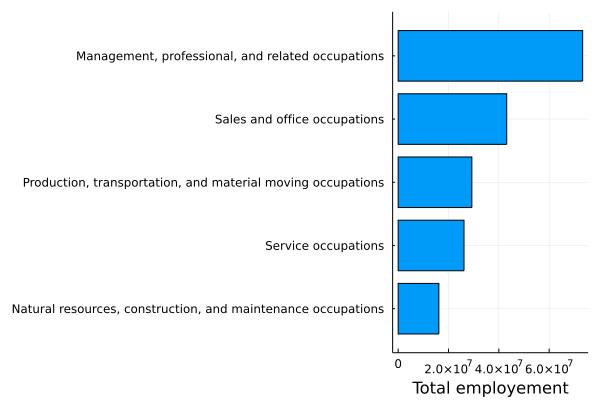

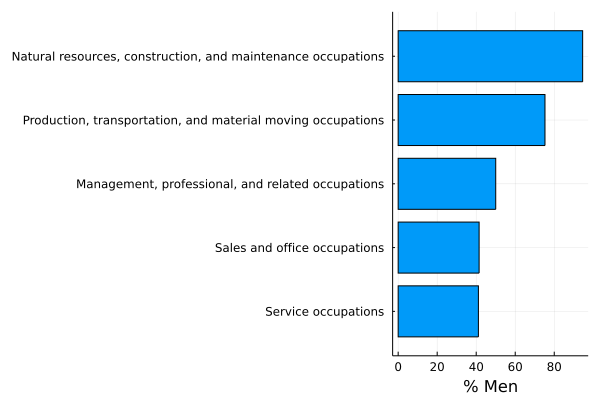

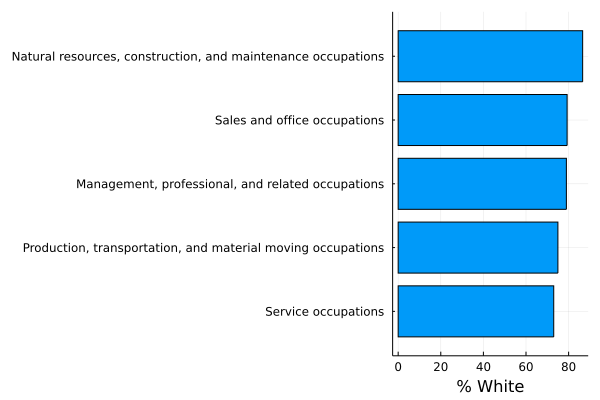

In [23]:
labels = [
    (:TOTAL, "Total employement"),
    (:perc_men, "% Men"),
    (:perc_white, "% White"),
]
for (col, label) in labels
    x = sort(major_occupations_latest, col)
    display(bar(x.major_occupation, x[!,col],
        orientation = :horizontal,
        yticks = :all,
        legend = false,
        xlabel = label,
    ))
end

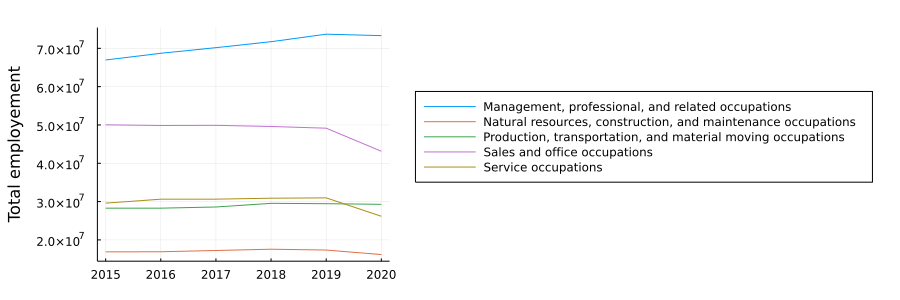

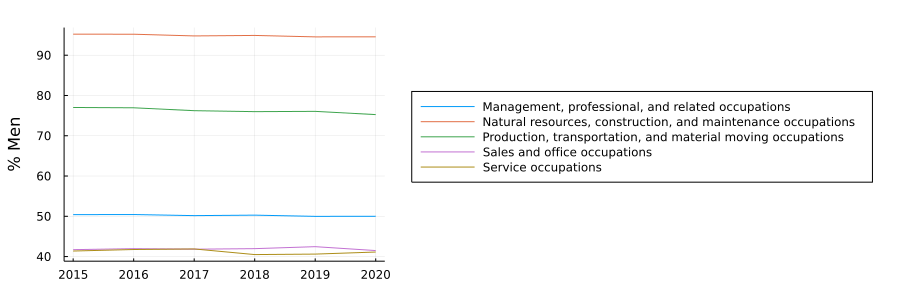

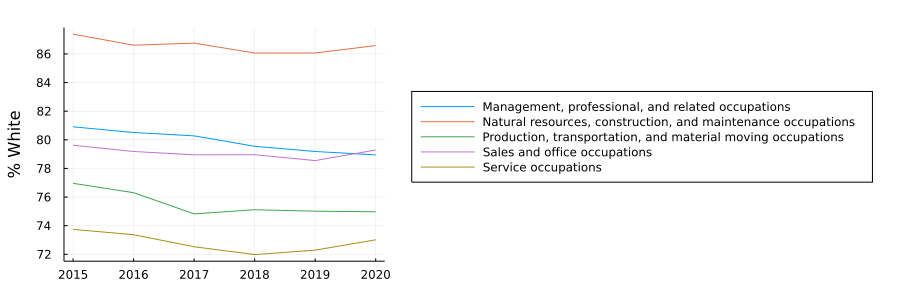

In [24]:
labels = [
    (:TOTAL, "Total employement"),
    (:perc_men, "% Men"),
    (:perc_white, "% White"),
]
for (col, label) in labels
    display(plot(
        major_occupations.year, major_occupations[!,col],
        group = major_occupations.major_occupation,
        legend = :outerright,
        ylabel = label,
        size=(900,300),
        margin = 5mm,
    ))
end

### Minor occupations

In [25]:
minor_occupations = @pipe employed |>
    groupby(_, [:minor_occupation, :race_gender, :year]) |>
    combine(_, :employ_n => sum) |>
    unstack(_, [:minor_occupation, :year], :race_gender, :employ_n_sum)
minor_occupations.perc_men = @. 100 * minor_occupations.Men / minor_occupations.TOTAL
minor_occupations.perc_white = @. 100 * minor_occupations.White / minor_occupations.TOTAL
minor_occupations_latest = @pipe minor_occupations |>
    filter(:year => ==(max(industries.year...)), _)
minor_occupations_latest

11×10 DataFrame
 Row │ minor_occupation                   year   TOTAL     Men       Women     White     Black or African American  Asian    perc_men  perc_white 
     │ String                             Int64  Int64?    Int64?    Int64?    Int64?    Union{Missing, Int64}      Int64?   Float64   Float64    
─────┼────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   1 │ Management, business, and financ…   2020  32357000  18121000  14239000  26567000                    2728000  2159000   56.0033     82.1059
   2 │ Professional and related occupat…   2020  40957000  18541000  22417000  31312000                    4178000  4252000   45.2694     76.4509
   3 │ Protective service occupations      2020   3144000   2400000    746000   2350000                     603000    78000   76.3359     74.7455
   4 │ Service occupations, except prot…   2020  23022000   8361000  14663000  16755000                    3677000  1566000   36.3174     72.7782
   5 │ Sales and related occupations       2020  23917000  12415000  11503000  19161000                    2512000  1323000   51.9087     80.1146
   6 │ Office and administrative suppor…   2020  19216000   5481000  13734000  15040000                    2607000   879000   28.5231     78.2681
   7 │ Farming, fishing, and forestry o…   2020   1110000    835000    275000    999000                      48000    19000   75.2252     90.0
   8 │ Construction and extraction occu…   2020   8163000   7834000    328000   7160000                     578000   127000   95.9696     87.7129
   9 │ Installation, maintenance, and r…   2020   6898000   6623000    278000   5843000                     598000   211000   96.0133     84.7057
  10 │ Production occupations              2020  13887000   9939000   3949000  10774000                    1835000   797000   71.5705     77.5834
  11 │ Transportation and material movi…   2020  15400000  12100000   3301000  11183000                    2931000   639000   78.5714     72.6169

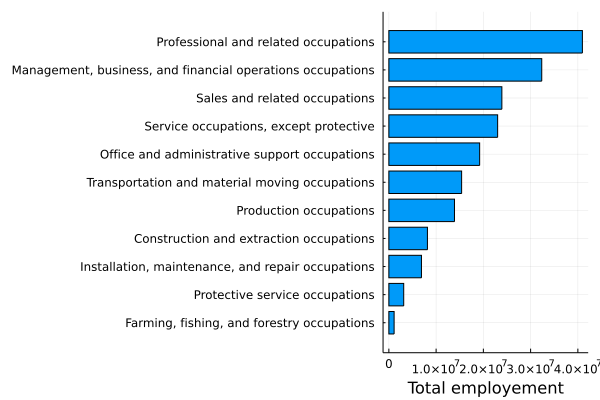

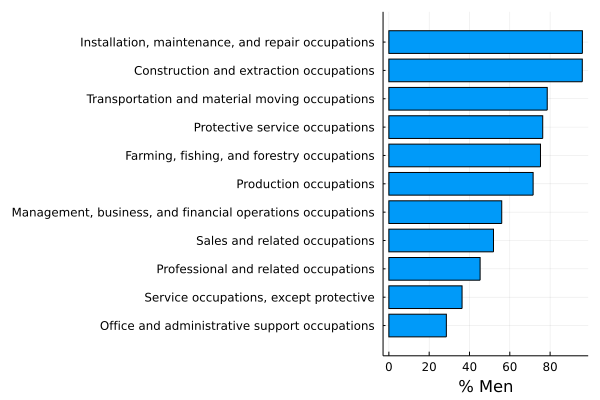

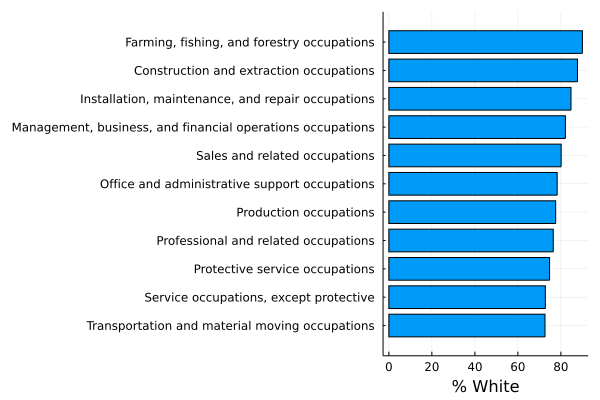

In [26]:
labels = [
    (:TOTAL, "Total employement"),
    (:perc_men, "% Men"),
    (:perc_white, "% White"),
]
for (col, label) in labels
    x = sort(minor_occupations_latest, col)
    display(bar(x.minor_occupation, x[!,col],
        orientation = :horizontal,
        yticks = :all,
        legend = false,
        xlabel = label,
    ))
end

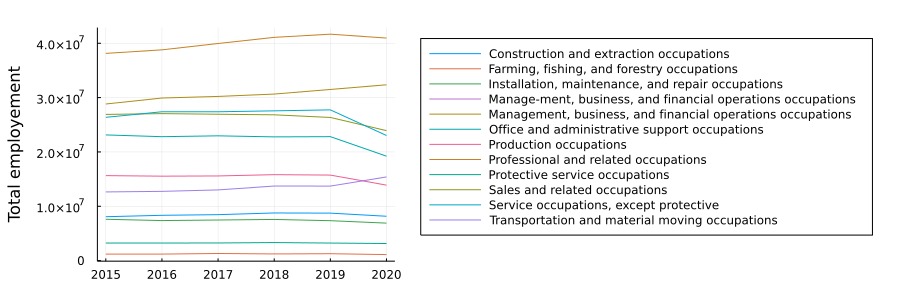

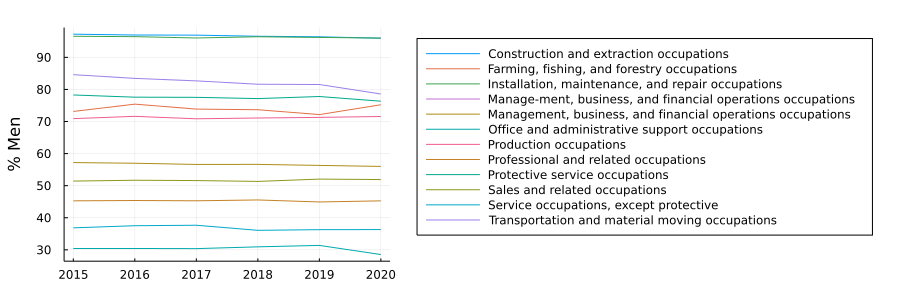

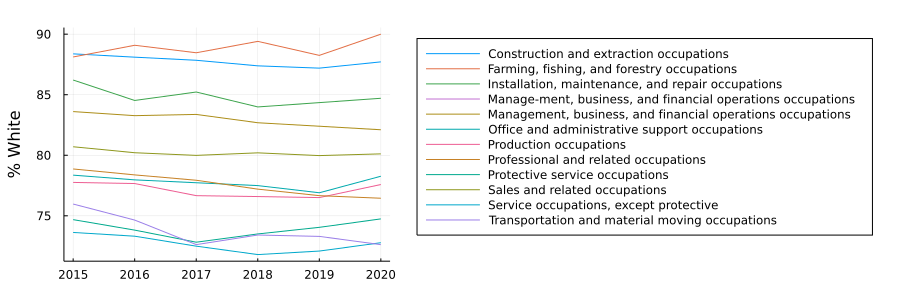

In [27]:
labels = [
    (:TOTAL, "Total employement"),
    (:perc_men, "% Men"),
    (:perc_white, "% White"),
]
for (col, label) in labels
    display(plot(
        minor_occupations.year, minor_occupations[!,col],
        group = minor_occupations.minor_occupation,
        legend = :outerright,
        ylabel = label,
        size=(900,300),
        margin = 5mm,
    ))
end